In this section, calcium fluxes in a compartmentalized cell were modelled. Calcium can be present in the cytosol ($Ca_{cyt}$), bound to calcium binding proteins residing in the cytosol ($CaPr$), the Endoplasmic Reticulum (ER) ($Ca_{ER}$) as well as the mitochondria ($Ca_m$). 
The total calcium concentration ($Ca_{tot}$) can therefore be defined as:

$Ca_{tot} = Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}}+Ca_{ER}+\frac{\rho_{m}}{\beta_{m}}+Ca_{m}+CaPr$

The total amount of the calcium binding protein ($Pr_{tot}$) in it's bound ($CaPr$) or unbound ($Pr$) form is defined as:

$Pr_{tot} = Pr + CaPr$

To desribe the rate of change of calcium conatnrations in the different compartments the following formulas can be used:

$\frac{dCa_{cyt}}{dt} = J_{ch} + J_{leak} - J_{pump} + J_{out} - J_{in} + k_- CaPr - k_+ Ca_{cyt}Pr$

In [1]:
#Import statements

# Basic Imports
from __future__ import division
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import math
import copy
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display, HTML
import sympy.solvers.ode
from sympy import *
import copy
import random as rd

# Define the flux equations

def fluxPump(k_pump,Ca_cyt):
    return k_pump*Ca_cyt

def fluxCh(k_ch, Ca_cyt,Ca_ER,K1):
    return k_ch*((Ca_cyt**2)/(K1**2 + Ca_cyt**2))*(Ca_ER - Ca_cyt)

def fluxLeak(k_leak, Ca_ER, Ca_cyt):
    return k_leak*(Ca_ER - Ca_cyt)

def fluxIn(k_in, K2, Ca_cyt):
    return k_in*(Ca_cyt**8/(K2**8 + Ca_cyt**8))

def fluxOut(k_out, K3, Ca_cyt, km, Ca_m):
    return Ca_m*(k_out*(Ca_cyt**2 / (K3**2 + Ca_cyt**2))+km)

def calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m):
    return Ca_tot - (Ca_ER*(p_ER/b_ER)) - (Ca_m*(p_m/b_m)) - Ca_cyt

def calcPr(Pr_tot, CaPr):
    return Pr_tot - CaPr

# Differential equations

def dCa_cyt(J_ch, J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr):
    return J_ch + J_leak - J_pump + J_out - J_in + (k_minus*CaPr) - (k_plus*Ca_cyt*Pr)

def dCa_ER(beta_ER, rho_ER, J_pump, J_ch, J_leak):
    return (beta_ER/rho_ER)*(J_pump - J_ch - J_leak)

def dCa_m(beat_m, rho_m, J_in, J_out):
    return (beta_m/rho_m)*(J_in-J_out)    

# System of Ordinary Differential Equation

def ODE_Calcium_Sys(y0, t, Ca_tot, Pr_tot, p_ER, p_m, b_ER, b_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3):
    '''This function defines the system of ODES which controls the levels of calcium in the system'''
    
    # Separate initial conditions
    Ca_cyt, Ca_ER, Ca_m = y0
    
    # calculate dependent variables
    CaPr = calcCaPr(Ca_tot, Ca_cyt, Ca_ER, Ca_m, p_ER, p_m, b_ER, b_m)
    Pr = calcPr(Pr_tot, CaPr)
    J_pump = fluxPump(k_pump, Ca_cyt)
    J_ch = fluxCh(k_ch,Ca_cyt,Ca_ER,K1)
    J_leak = fluxLeak(k_leak, Ca_ER, Ca_cyt)
    J_in = fluxIn(k_in, K2, Ca_cyt)
    J_out = fluxOut(k_out, K3, Ca_cyt, k_m, Ca_m)
    
    Ca_cyt_1 = dCa_cyt(J_ch, J_leak, J_pump, J_in, J_out, k_minus, CaPr, k_plus, Ca_cyt, Pr)
    Ca_ER_1 = dCa_ER(beta_ER, rho_ER, J_pump, J_ch, J_leak)
    Ca_m_1 = dCa_m(beta_m, rho_m, J_in, J_out)
    
    return Ca_cyt_1, Ca_ER_1, Ca_m_1

In [20]:
# Declare parameters
#---------------------------------------
#Total concentrations (micro Moles)
Ca_tot =  90 
Pr_tot = 120

# Geometric Parameters

rho_ER = 0.01
rho_m = 0.01
beta_ER = 0.0025
beta_m = 0.0025

#Kinetics parameters

k_ch = 4100 #s^-1
k_pump = 20 #s^-1
k_leak = 0.05 #s^-1
k_in = 300 #(micro Moles s^-1)
k_out = 125 #s^-1
k_m = 0.00625 #s^-1
k_plus = 0.1 #(micro Moles)
k_minus = 0.01 #s^-1
K1 = 5 #(micro Moles)
K2 = 0.8 #(micro Moles)
K3 = 5 #(micro Moles)

#Initial concentrations (micro Moles)

Ca_cyt_0 = 0.3 
Ca_ER_0 = 0.2
Ca_m_0 = 1

#Run the system

time_steps = np.arange(0,300,0.01)

start = int(100/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

In [21]:
#print(calcium_over_time.T)

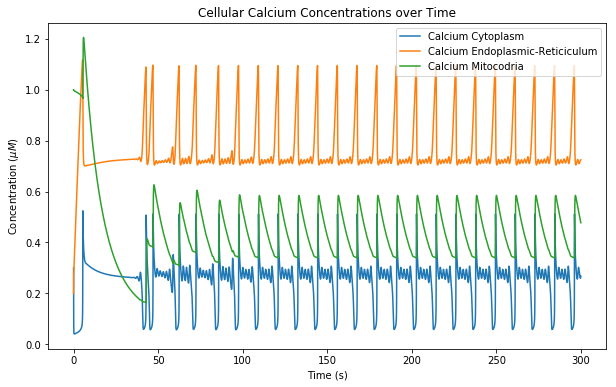

In [22]:
plt.figure(0,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()

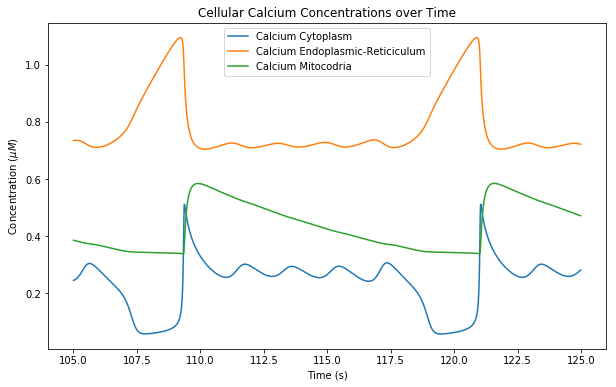

In [40]:
zoom_start = int(105/0.01)
zoom_end = int(125/0.01)
plt.figure(0,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps[zoom_start:zoom_end], calcium_over_time[i][zoom_start:zoom_end], label = plt_labels[i])
plt.legend()

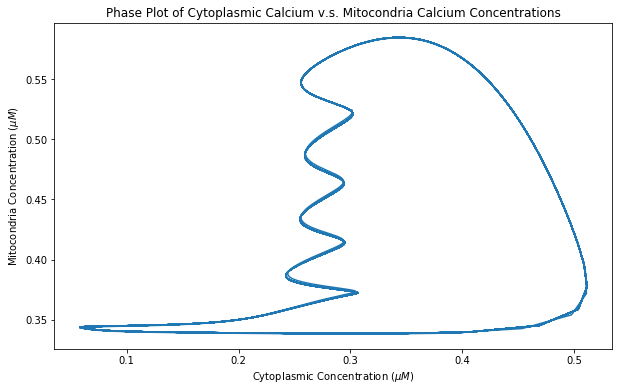

In [41]:
plt.figure(1,figsize = (10,6))
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])

Text(0.5, 0.92, 'Phase Plot of Calcium Concentrations')

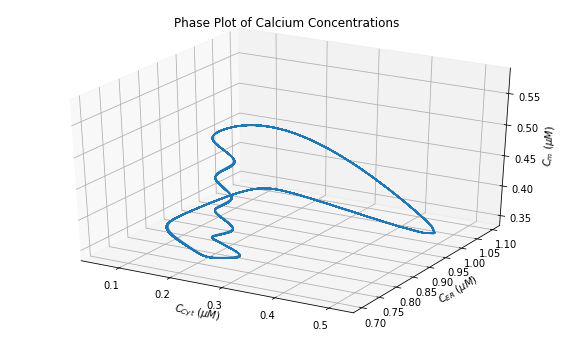

In [42]:
fig = plt.figure(2,figsize = (10,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')


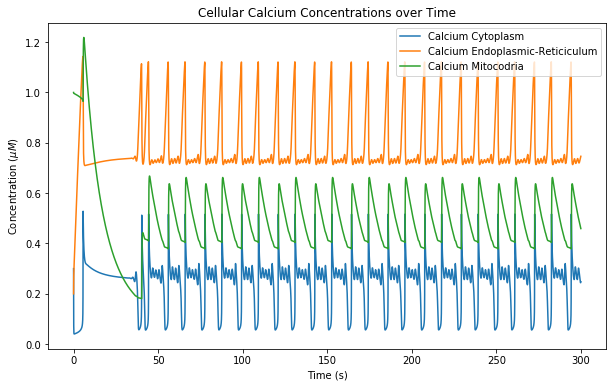

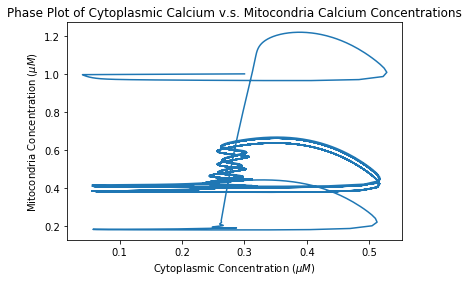

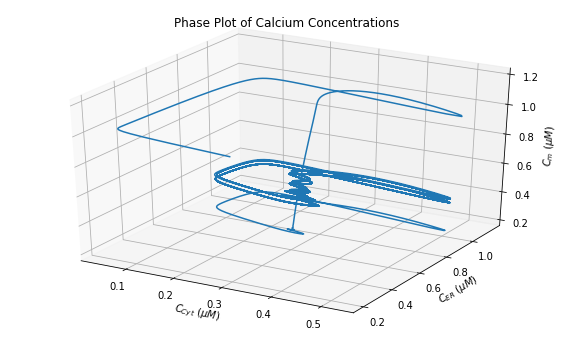

In [44]:
k_ch = 4000
start = int(0/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

plt.figure(3,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

plt.figure(4)
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

fig = plt.figure(5,figsize = (10,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

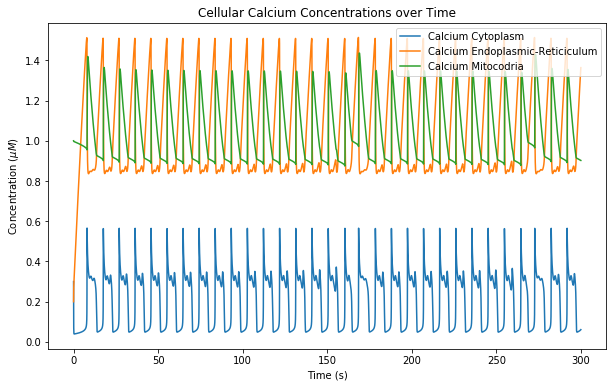

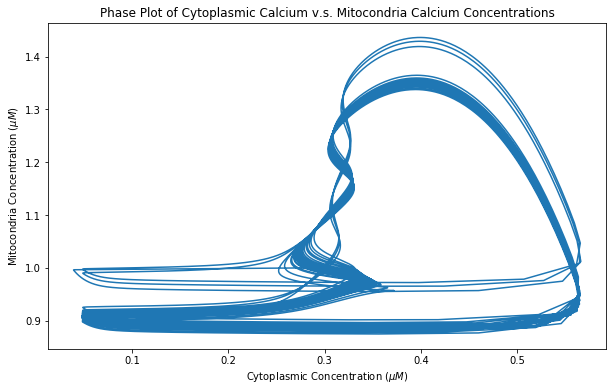

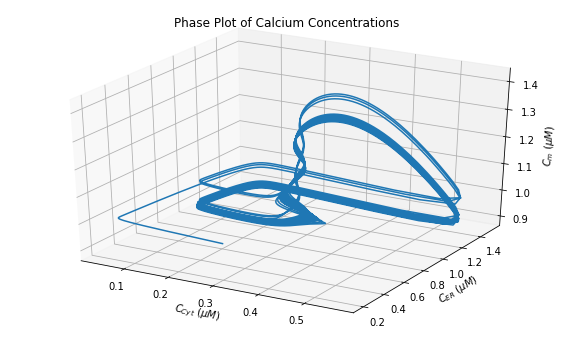

In [45]:
k_ch = 2950
start = int(0/0.01)
end = int(300/0.01)

calcium_over_time = odeint(ODE_Calcium_Sys, (Ca_cyt_0,Ca_ER_0,Ca_m_0), time_steps, args = (Ca_tot, Pr_tot, rho_ER, rho_m, beta_ER, beta_m, k_ch, k_pump, k_leak, k_in, k_out, k_m, k_plus, k_minus, K1,K2,K3))
calcium_over_time = calcium_over_time.T

plt.figure(6,figsize = (10,6))
plt.title("Cellular Calcium Concentrations over Time")
plt.xlabel('Time (s)')
plt.ylabel('Concentration ($\mu M$)')
plt_labels = ['Calcium Cytoplasm', 'Calcium Endoplasmic-Reticiculum', 'Calcium Mitocodria']
for i in range(0,len(calcium_over_time)):
    plt.plot(time_steps, calcium_over_time[i], label = plt_labels[i])
plt.legend()
plt.show()

plt.figure(7,figsize = (10,6))
plt.title("Phase Plot of Cytoplasmic Calcium v.s. Mitocondria Calcium Concentrations")
plt.xlabel('Cytoplasmic Concentration ($\mu M$)')
plt.ylabel('Mitocondria Concentration ($\mu M$)')
plt.plot(calcium_over_time[0][start:end], calcium_over_time[2][start:end])
plt.show()

fig = plt.figure(8,figsize = (10,6))
ax = plt.axes(projection='3d')
ax.set_xlabel('$C_{Cyt}$ ($\mu M$)')
ax.set_ylabel('$C_{ER}$ ($\mu M$)')
ax.set_zlabel('$C_m$ ($\mu M$)')
ax.plot3D(calcium_over_time[0][start:end], calcium_over_time[1][start:end], calcium_over_time[2][start:end])
plt.title('Phase Plot of Calcium Concentrations')
plt.show()

## 2 Introduction to Pattern Formation

In this part of the experiment, pattern formation in bioligical systems was analyzed by simulating the systems with a system of reaction diffusion equations and by solving them using the finite difference method.  In this experiment 2 different systems were analysed, the Grierer-Meinhardt system and the Schnakenberg system.  The Grierer-Meinhardt and the Schnakenberg systems are activator inhibitor systems that appears to account for many important types of patter formation morephogenesis observered during development.  It has been shown to explain the formation of organising regions and pattern formation.

A reaction diffusion system take the form of:

$\frac{\partial u}{\partial t}=D_{u} \nabla^{2} u+f(u)$

where $u$ is the concentration of substance u, $D_u$ is the diffusion constant which controls the rate of diffusion, and $f(u)$ is the reation equation created by using the law of mass actions.

For the systems in this experiment, there are two different substances, u and v, the activator and inhibitor respectivly.  In the Grierer-Meinhardt system the reaction equation for the two substances are defined as:

$f_u(u, v)=c_{1}-c_{2} u+c_{3} \frac{u^{2}}{\left(1+k u^{2}\right) v}$

$f_v(u, v)=c_{4} u^{2}-c_{5} v$

where $u$ is the concentration of the activator, $v$ is the concentration of the inhibitor, $c_{1}$ is the rate of production of u, $c_{2}$ is the rate of decay of u, $c_{3}$ is the rate that production of u is stimulated by u and v, $c_{4}$ is the rate of production of v, and $c_{5}$ is the rate of decay of v. The parameter k is a constant to take into consideration the regulation of the system.  

The Grierer-Meinhardt system was defined to exist in a 1x1 box grid with step sizes of 0.02 in both the x and y direction. Initial concentrations v and u would be a random start distribution between 0.999 and 1.001 for u and between 1.999 and 2.001 for v.  For the system, boundary conditions were set such that the rate of change around the boundary is 0, i.e $u_{x}(0,y, t)=u_{x}(1,y, t)=v_{x}(0, y, t)=v_{x}(1,y, t)=u_{y}(x,0, t)=u_{y}(x,1, t)=v_{y}(x, 0, t)=v_{y}(x,1, t)=0$.

In the Schnakenberg system the reaction equation for the two substances are defined as:

$f_u(u, v)=c_{1}-c_{-1} u+c_{3} u^{2} v$

$f_v(u, v)=c_{2}-c_{3} u^{2} v$

where $u$ is the concentration of the activator, $v$ is the concentration of the inhibitor, $c_{1}$ is the rate of production of u, $c_{-1}$ is the rate of decay of u, $c_{3}$ is the rate that production of u is stimulated by u and inhibited v, $c_{2}$ is the rate of production of v, and $c_{3}$ is the rate of decay of v.

The Schnakenberg system was defined to exist in a 1x1 box grid with step sizes of 0.02 in both the x and y direction. Initial concentrations v and u would be a random start distribution between 0.999 and 1.001 for u and between 2.999 and 3.001 for v.  For the system, periodic boundary conditions were set such that, $u(0,y,t)=u(1,y,t)$, $u(x,0,t)=u(x,1,t)$, $v(0,y,t)=v(1,y,t)$, $v(x,0,t)=v(x,1,t)$.

Now that the reaction diffusion equations and the boundary conditions have been defined, the Grierer-Meinhardt was solved using the finite difference method to determine what happens to a system over time.  To initial the system it was taken that the concentrations of v and u would be a random start distribution between 0.999 and 1.001 for u and between 1.999 and 2.001 for v.  The constants were defined as $D_u = 0.0004$, $D_v = 0.04$, $c_1 = 1$, $c_2 = 1$, $c_3 = 2$, $c_4 = 2$, $c_5 = 0$, $k = 1$, $dt = 0.001$ and $dx = 0.02$.  With these values the system was run for 10 time intervals.  The resulting graphs for u and v over time can be seen below.

In [2]:
def laplacian(Z):
    dx = 2/100
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

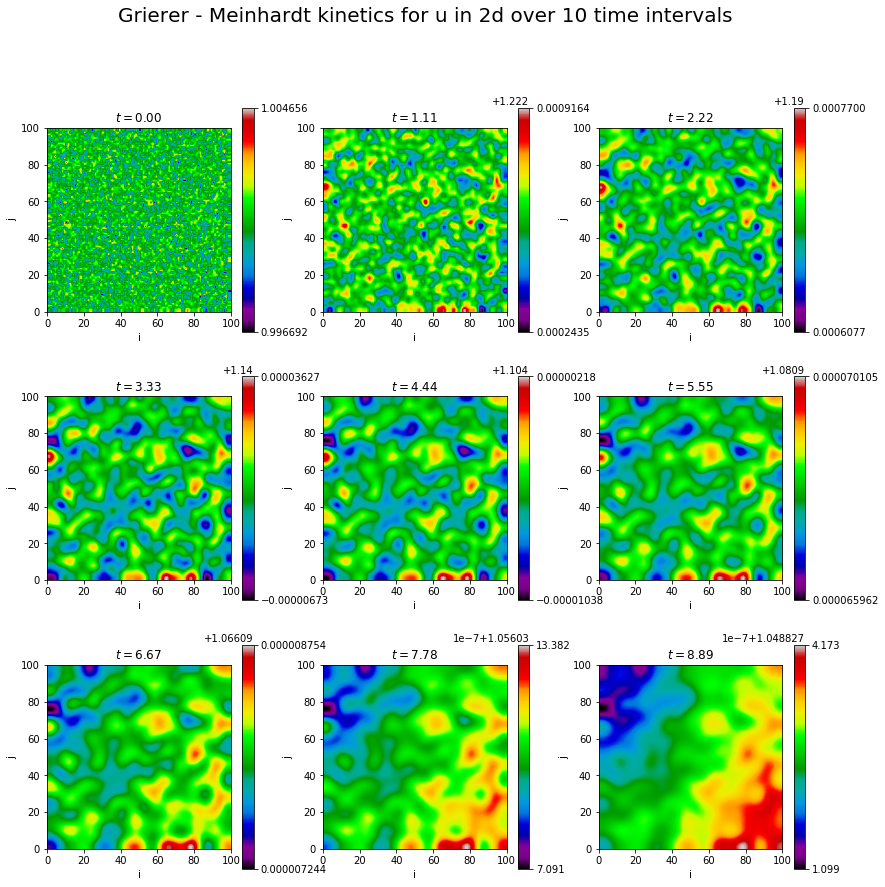

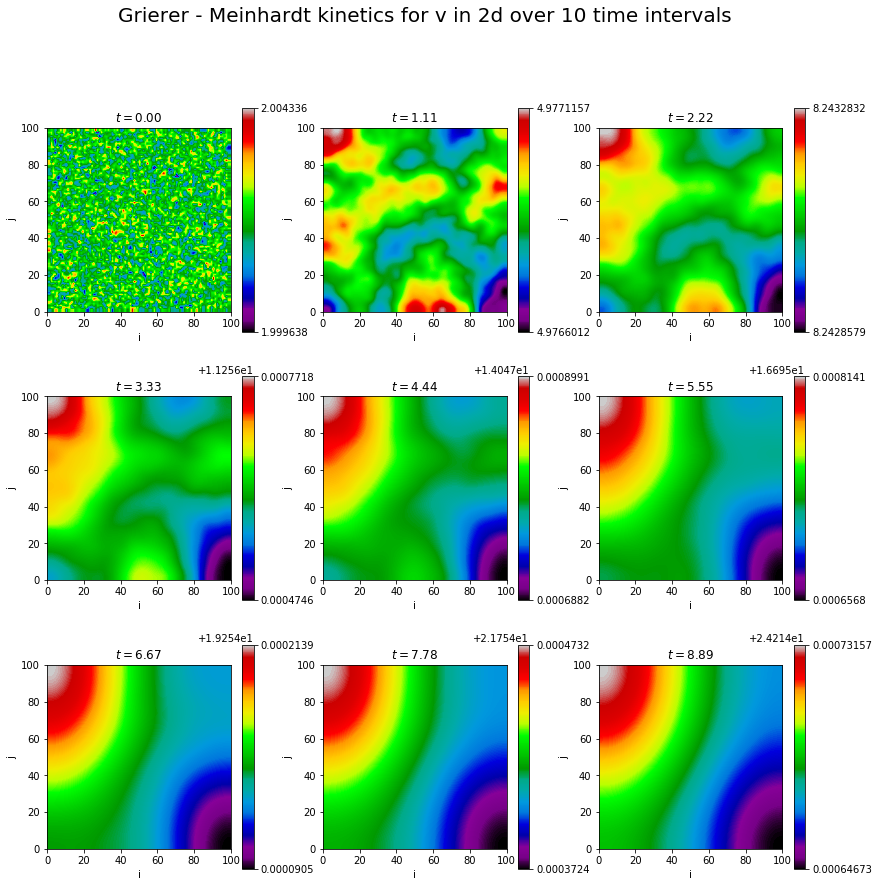

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
size = 100

U = np.random.normal(1., 0.001, size=(size,size))
V = np.random.normal(2., 0.001, size=(size,size))
count = 1

t = 10
dt = 1./1000

n = int(t/dt)

Du = 0.0004 
Dv = 0.04
c1 = 1. 
c2 = 1. 
c3 = 2. 
c4 = 2. 
c5 = 0. 
k = 1.

v_time = []

fig = plt.figure(1,figsize=(14, 14))
fig.suptitle("Grierer - Meinhardt kinetics for u in 2d over "+str(t)+" time intervals", size = 20)
step_plot = n // 9
# We simulate the PDE with the finite difference
# method.
for i in range(n):
    # We compute the Laplacian of u and v.
    deltaU = laplacian(U)
    deltaV = laplacian(V)
    # We take the values of u and v inside the grid.
    Uc = U[1:-1, 1:-1].copy()
    Vc = V[1:-1, 1:-1].copy()
    f_u = c1 - c2*Uc + (c3*(Uc**2)/((1+k*Uc**2)*Vc))
    f_v = c4*Uc**2 - c5*Vc
    # We update the variables.
    U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Uc + dt * (Du*deltaU + f_u),\
        Vc + dt * (Dv*deltaV + f_v) 
    # Neumann conditions: derivatives at the edges
    # are null.
    for Z in (U, V):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # We plot the state of the system at
    # 9 different times.
    v_time.append(V.copy())
    if i % step_plot == 0 and i < 9 * step_plot:
        #print(i)
        a = fig.add_subplot(3,3,count)
        count +=1
        #ax = axes.flat[i // step_plot]
        plt.imshow(U, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
        #ax.set_axis_off()
        a.set_title(f'$t={i * dt:.2f}$')
        plt.xlabel("i")
        plt.ylabel("j")
        cbar = plt.colorbar(ticks=[np.min(U), np.max(U)])
        
plt.show()

fig = plt.figure(1,figsize=(14, 14))
fig.suptitle("Grierer - Meinhardt kinetics for v in 2d over "+str(t)+" time intervals", size = 20)

i = 0
count = 1

for i in range(n):
    if i % step_plot == 0 and i < 9 * step_plot:
        #print(i)
        a = fig.add_subplot(3,3,count)
        count +=1
        #ax = axes.flat[i // step_plot]
        plt.imshow(v_time[i], cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
        #ax.set_axis_off()
        a.set_title(f'$t={i * dt:.2f}$')
        plt.xlabel("i")
        plt.ylabel("j")
        cbar = plt.colorbar(ticks=[np.min(v_time[i]), np.max(v_time[i])])
        
plt.show()

# diff = v_time[-2] - v_time[-1]

# plt.imshow(diff, cmap=plt.cm.nipy_spectral,
#               interpolation='bilinear',
#               extent=[0, 100, 0, 100])

In this system, the diffusion part of the equation causes the system to try and equlized over time, but the reaction part of the equation changes the concentraions at each time step.  The figures above show the concentration of u(the activator) and v(the inhibitor) over time, it can be seen that as the concentration of u increases in an area, it starts to amplyfy itself, further increasing the production.  If the area has a high concentration of u and v, more v is produced and the concentration of u decreases while the concentration of v begins to increase.  If the concentrations are in the right ratio, then they will both increase without the other inhibiting the production.  Since $c_5$ is 0 in this case, v will never decay. When the concentration of v is small,  more u is produced as a result, but this is only in the case when $0\leq v \leq 1$, which does not occur in this system as v is initialized around 2.  It can be seen that there appears to be an uneven front of high coencentration of u spreading through the system from an area of raised concentration of u where the ratio of v to u was right for the spread.  The same can be seen in the production of v where it starts in an area of high concentration of u and incereases production as the concentration of u increases through the system.  As would be expected, where there are lower concentraions of u, there are higher concentrations of v.  As can be seen the concentrations of v becomes almost equal through the system as time increases, probaably due to the lack of decay.  The patter in v is reminiscent of some seashell patterns and also of the controlling concentraions for some gene expressions.

In the next part of this experiment the Schnakenberg model was solved using the finite difference method to determine what happens to a system over time.  To initial the system it was taken that the concentrations of v and u would be a random start distribution between 0.999 and 1.001 for u and between 2.999 and 3.001 for v.  The constants were defined as $D_u = 0.0004$, $D_v = 0.016$, $c_1 = 0.1$, $c_{-1} = 1$, $c_2 = 0.9$, $c_3 = 1$, $dt = 0.001$ and $dx = 0.02$.  With these values the system was run for 35 time intervals.  The resulting graphs for u and v over time can be seen below.

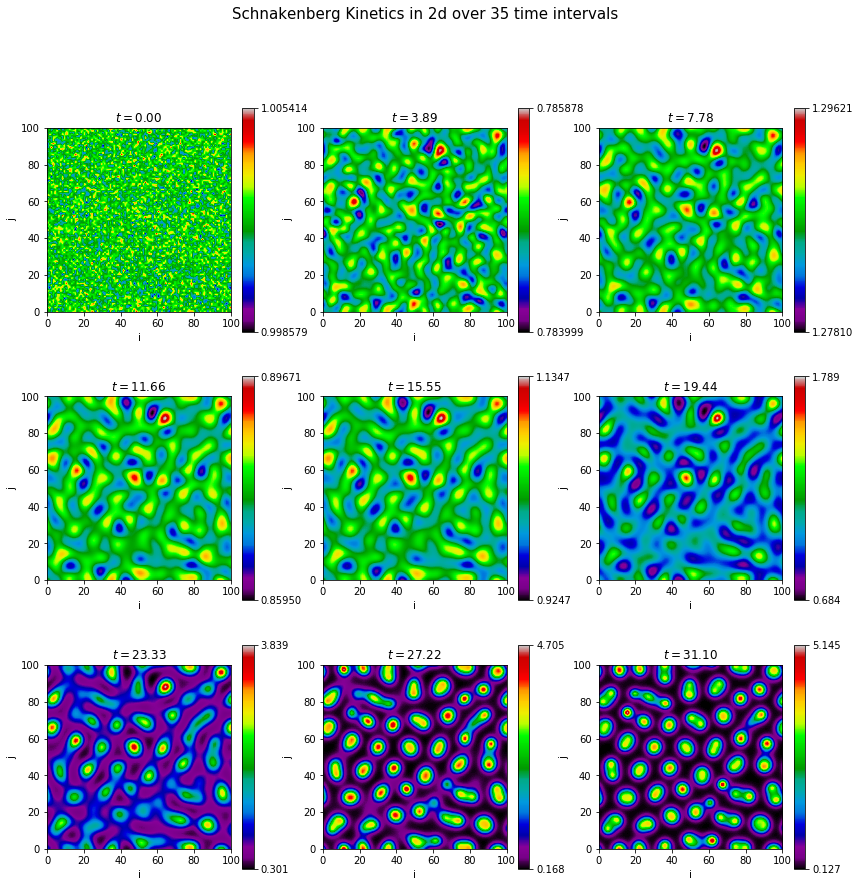

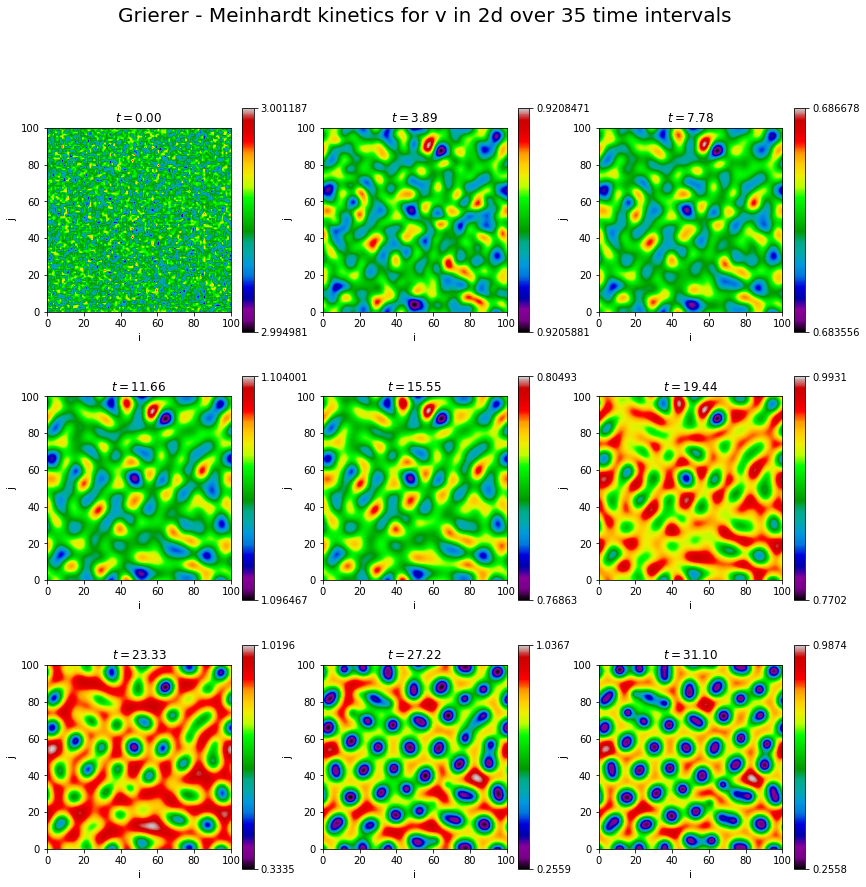

In [22]:
size = 100

U = np.random.normal(1., 0.001, size=(size,size))
V = np.random.normal(3., 0.001, size=(size,size))
count = 1
v_time = []

t = 35
dt = 1/1000

n = int(t/dt)

Du = 0.0004
Dv = 0.016
c1 = 0.1
c1min = 1
c2 = 0.9
c3 = 1

fig = plt.figure(1,figsize=(14, 14))
fig.suptitle("Schnakenberg Kinetics in 2d over "+str(t)+" time intervals", size = 15)
step_plot = n // 9
# We simulate the PDE with the finite difference
# method.
for i in range(n):
    # We compute the Laplacian of u and v.
    deltaU = laplacian(U)
    deltaV = laplacian(V)
    # We take the values of u and v inside the grid.
    Uc = U[1:-1, 1:-1]
    Vc = V[1:-1, 1:-1]
    f_u = c1 - c1min*Uc + (c3*Uc**2)*Vc
    f_v = c2 -(c3*Uc**2)*Vc
    # We update the variables.
    U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Uc + dt * (Du*deltaU + f_u),\
        Vc + dt * (Dv*deltaV + f_v) 
    # Neumann conditions: derivatives at the edges
    # are null.
    for Z in (U, V):
        Z[0, :] = Z[-2, :]
        Z[-1, :] = Z[1, :]
        Z[:, 0] = Z[:, -2]
        Z[:, -1] = Z[:, 1]

    # We plot the state of the system at
    # 9 different times.
    v_time.append(V.copy())
    if i % step_plot == 0 and i < 9 * step_plot:
        #print(i)
        a = fig.add_subplot(3,3,count)
        count +=1
        #ax = axes.flat[i // step_plot]
        plt.imshow(U, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
        plt.xlabel("i")
        plt.ylabel("j")
        #ax.set_axis_off()
        a.set_title(f'$t={i * dt:.2f}$')
        cbar = plt.colorbar(ticks=[np.min(U), np.max(U)], shrink = True)
plt.show()
fig = plt.figure(2,figsize=(14, 14))
fig.suptitle("Grierer - Meinhardt kinetics for v in 2d over "+str(t)+" time intervals", size = 20)

i = 0
count = 1

for i in range(n):
    if i % step_plot == 0 and i < 9 * step_plot:
        #print(i)
        a = fig.add_subplot(3,3,count)
        count +=1
        #ax = axes.flat[i // step_plot]
        plt.imshow(v_time[i], cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
        #ax.set_axis_off()
        a.set_title(f'$t={i * dt:.2f}$')
        plt.xlabel("i")
        plt.ylabel("j")
        cbar = plt.colorbar(ticks=[np.min(v_time[i]), np.max(v_time[i])])
        
plt.show()

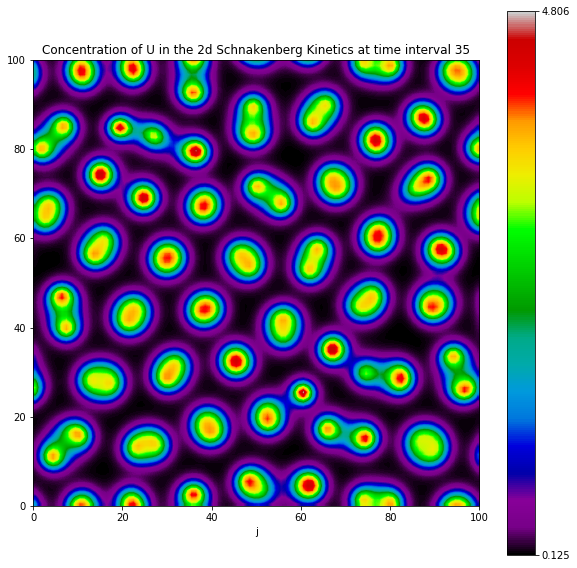

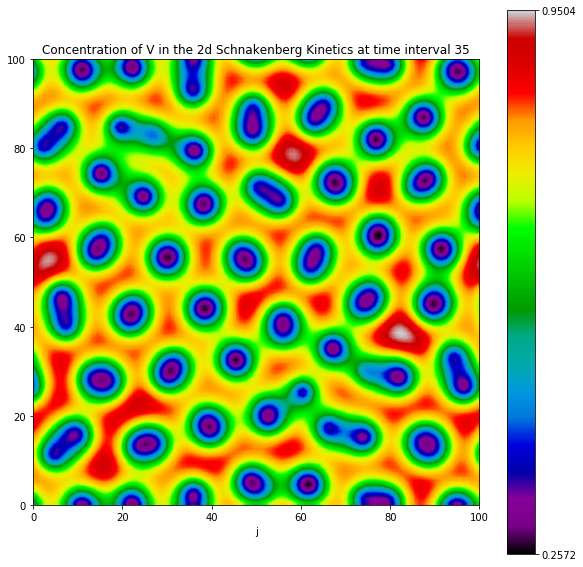

In [23]:
plt.figure(3, figsize=(10,10))
plt.title("Concentration of U in the 2d Schnakenberg Kinetics at time interval 35")
plt.xlabel('i')
plt.xlabel('j')

plt.imshow(U, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
plt.colorbar(ticks=[np.min(U), np.max(U)], shrink = True)
plt.show()

plt.figure(4, figsize=(10,10))
plt.title("Concentration of V in the 2d Schnakenberg Kinetics at time interval 35")
plt.xlabel('i')
plt.xlabel('j')

plt.imshow(V, cmap=plt.cm.nipy_spectral,
              interpolation='bilinear',
              extent=[0, 100, 0, 100])
plt.colorbar(ticks=[np.min(V), np.max(V)], shrink = True)
plt.show()

In this reaction diffusion system, there is a source of u (activator) and v (inhibitor) which produces at a constant rate.  The concentration of u decreases as the ammount of u present increases, but this is countered by the 2nd order u increase of u when v is present in the system, but v also decays at the same rate as u increases.  This leads to some interesting dynamics which can be observed above.  At the start, higher concentration areas of u beginn to form, and in response, the concentration of v desreases, but in the lower concentration areas of u, v begins to produce faster than it decays/is used.  As this occurs isolated pockets of u begin to appear.  Over time, the system seems to be appriaching steady state, with higher concentrations of u surrounded by higher concentrations of v in a "bubble" like pattern.  Next the state was shown at the end of the simulation time.  This can be seen below.  This appears to be the steady state of the system.  Looking at the graphs above, the patters appearing are similar to the patterns found on some seashells.